# Report for multi-asset option problem
## 1. Introduction and Model Assumption:
At t=0, given a multi-asset option with payoff at maturity T:

$$
\begin{array}{c}
(S^1_T \wedge S^2_T - K)^+  \\\
\end{array}
$$

where $a \wedge b$ takes minimum of a and b, $S^1_T, S^2_T$ are prices of 2 different assets at T.

To make it simple, assume prices at t=0 are all 1, and the dynamics of these assets under risk-neutral measure are Geometric BM:

$$
\begin{array}{c}
S^1_0 = S^2_0 = 1  \\\
\frac{dS^0_t}{S^0_t} = rdt \\\
\frac{dS^i_t}{S^i_t} = rdt + \sigma dW^i_t, i=1, 2
\end{array}
$$

where:
1. $dW^i_t$ is Q Brownian Motion
2. $\sigma$ is the same and constant for these 2 assets
3. $<dW^1_t, dW^2_t> = \rho dt$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [2]:
class MultiAssetGBM:
    """
        MultiAseet GBM Stochastic Process:
        for each asset, dSt = a*St*dt + b*St*dWt, <dWt1, dWt2>=rho
    """
    def __init__(self, S0, a, b, rho):
        """
            params
            :S0 (np.array) vector of initial asset prices
        """
        self.S0 = S0
        self.a = a
        self.b = b
        self.rho = rho
        self.num = len(S0) # number of assets
        
    def __repr__(self):
        return "MultiAssetGBM(S0={}, a={:.2f}, b={:.2f}, rho={:.2f})".format(self.S0, self.a, self.b, self.rho)
    
    def generate(self, T, n, N):
        """
            generate process on [0, T] by Euler Scheme
            params
            :n (int) number of discretization on [0, T]
            :N (int) number of paths
        """
        mu = [0] * self.num
        cov = np.ones((self.num, self.num)) * self.rho
        np.fill_diagonal(cov, 1)
        paths = []
        for _ in range(N):
            dWt = np.random.multivariate_normal(mu, cov, n)
            for j in range(n):
                if j == 0:
                    path = [self.S0]
                St = path[j]
                St_plus = St + self.a*St*T/n + self.b*np.sqrt(T/n)*St*dWt[j]
                path.append(St_plus)
            paths.append(path)
        return paths

## 2. Example Setting

Let Model params: 
- T = 1
- r = 0.04
- $\sigma$ = 0.2 
- $\rho$ = 0 
- n (number of discretization) = 100
- N (number of draws) = 1000

Let option params:
- K = 0.8

In [3]:
s0 = np.array([1]*2) # initial prices
T = 1
r = 0.02
sigma = 0.2
rho = 0
n = 100
N = 1000
K = 1
magbm = MultiAssetGBM(s0, r, sigma, rho)

In [4]:
np.random.seed(seed=42)
draws = magbm.generate(T, n, N)

### 2.1 Plot of first draw 

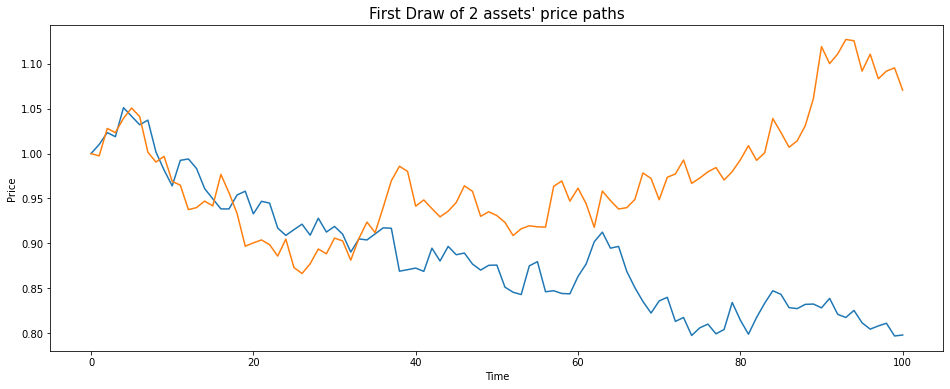

In [5]:
plt.figure(figsize=(16, 6))
plt.plot(draws[0])
plt.title(f"First Draw of 2 assets' price paths", size=15)
_ = plt.ylabel("Price"), plt.xlabel("Time")

### 2.2 Payoffs of option

In [6]:
payoffs = []
for i in range(N):
    payoff = max(min(draws[i][-1]) - K, 0)
    payoffs.append(payoff)

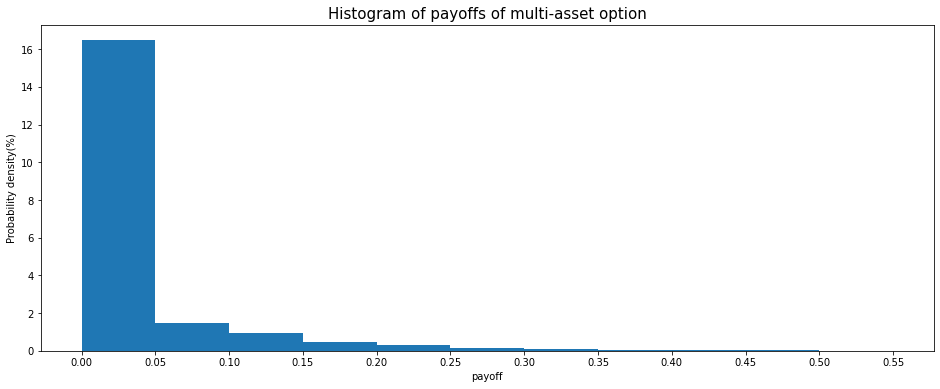

In [7]:
plt.figure(figsize=(16, 6))
xticks = np.arange(0, max(payoffs), 0.05)
plt.hist(payoffs, density=True, bins=xticks)
plt.xticks(xticks)
plt.title("Histogram of payoffs of multi-asset option", size=15)
_ = plt.ylabel("Probability density(%)"), plt.xlabel("payoff")

### 2.3 Price of option

In [8]:
price = np.exp(-r*T) * np.mean(payoffs)
print("Price of the multi-asset option: {:.4f}".format(price))

Price of the multi-asset option: 0.0262


## 3. Relationship between option price, volatility and correlation
Let: 
- $\sigma$ = `np.linspace(0, 0.4, 11)`
- $\rho$ = `np.linspace(-1, 1, 11)`

The rest is the same.

In [9]:
sigmas = np.linspace(0.0, 0.4, 9)
rhos = np.linspace(-1, 1, 9)
print("sigmas = {}\n  rhos = {}".format(sigmas, rhos))

sigmas = [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4 ]
  rhos = [-1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75  1.  ]


In [10]:
magbms = [] # models' container
for sigma in sigmas:
    for rho in rhos:
        magbms.append((sigma, rho, MultiAssetGBM(s0, r, sigma, rho)))

In [11]:
mdl_draws = [] # models' draws' container
for magbm in magbms:
    print("sigma={:.2f}, rho={:.2f}, model={}".format(magbm[0], magbm[1], magbm[2]))
    np.random.seed(seed=42)
    draw = magbm[2].generate(T, n, N)
    mdl_draws.append((magbm[0], magbm[1], draw))

sigma=0.00, rho=-1.00, model=MultiAssetGBM(S0=[1 1], a=0.02, b=0.00, rho=-1.00)
sigma=0.00, rho=-0.75, model=MultiAssetGBM(S0=[1 1], a=0.02, b=0.00, rho=-0.75)
sigma=0.00, rho=-0.50, model=MultiAssetGBM(S0=[1 1], a=0.02, b=0.00, rho=-0.50)
sigma=0.00, rho=-0.25, model=MultiAssetGBM(S0=[1 1], a=0.02, b=0.00, rho=-0.25)
sigma=0.00, rho=0.00, model=MultiAssetGBM(S0=[1 1], a=0.02, b=0.00, rho=0.00)
sigma=0.00, rho=0.25, model=MultiAssetGBM(S0=[1 1], a=0.02, b=0.00, rho=0.25)
sigma=0.00, rho=0.50, model=MultiAssetGBM(S0=[1 1], a=0.02, b=0.00, rho=0.50)
sigma=0.00, rho=0.75, model=MultiAssetGBM(S0=[1 1], a=0.02, b=0.00, rho=0.75)
sigma=0.00, rho=1.00, model=MultiAssetGBM(S0=[1 1], a=0.02, b=0.00, rho=1.00)
sigma=0.05, rho=-1.00, model=MultiAssetGBM(S0=[1 1], a=0.02, b=0.05, rho=-1.00)
sigma=0.05, rho=-0.75, model=MultiAssetGBM(S0=[1 1], a=0.02, b=0.05, rho=-0.75)
sigma=0.05, rho=-0.50, model=MultiAssetGBM(S0=[1 1], a=0.02, b=0.05, rho=-0.50)
sigma=0.05, rho=-0.25, model=MultiAssetGBM(S0=[1 1

<IPython.core.display.Javascript object>


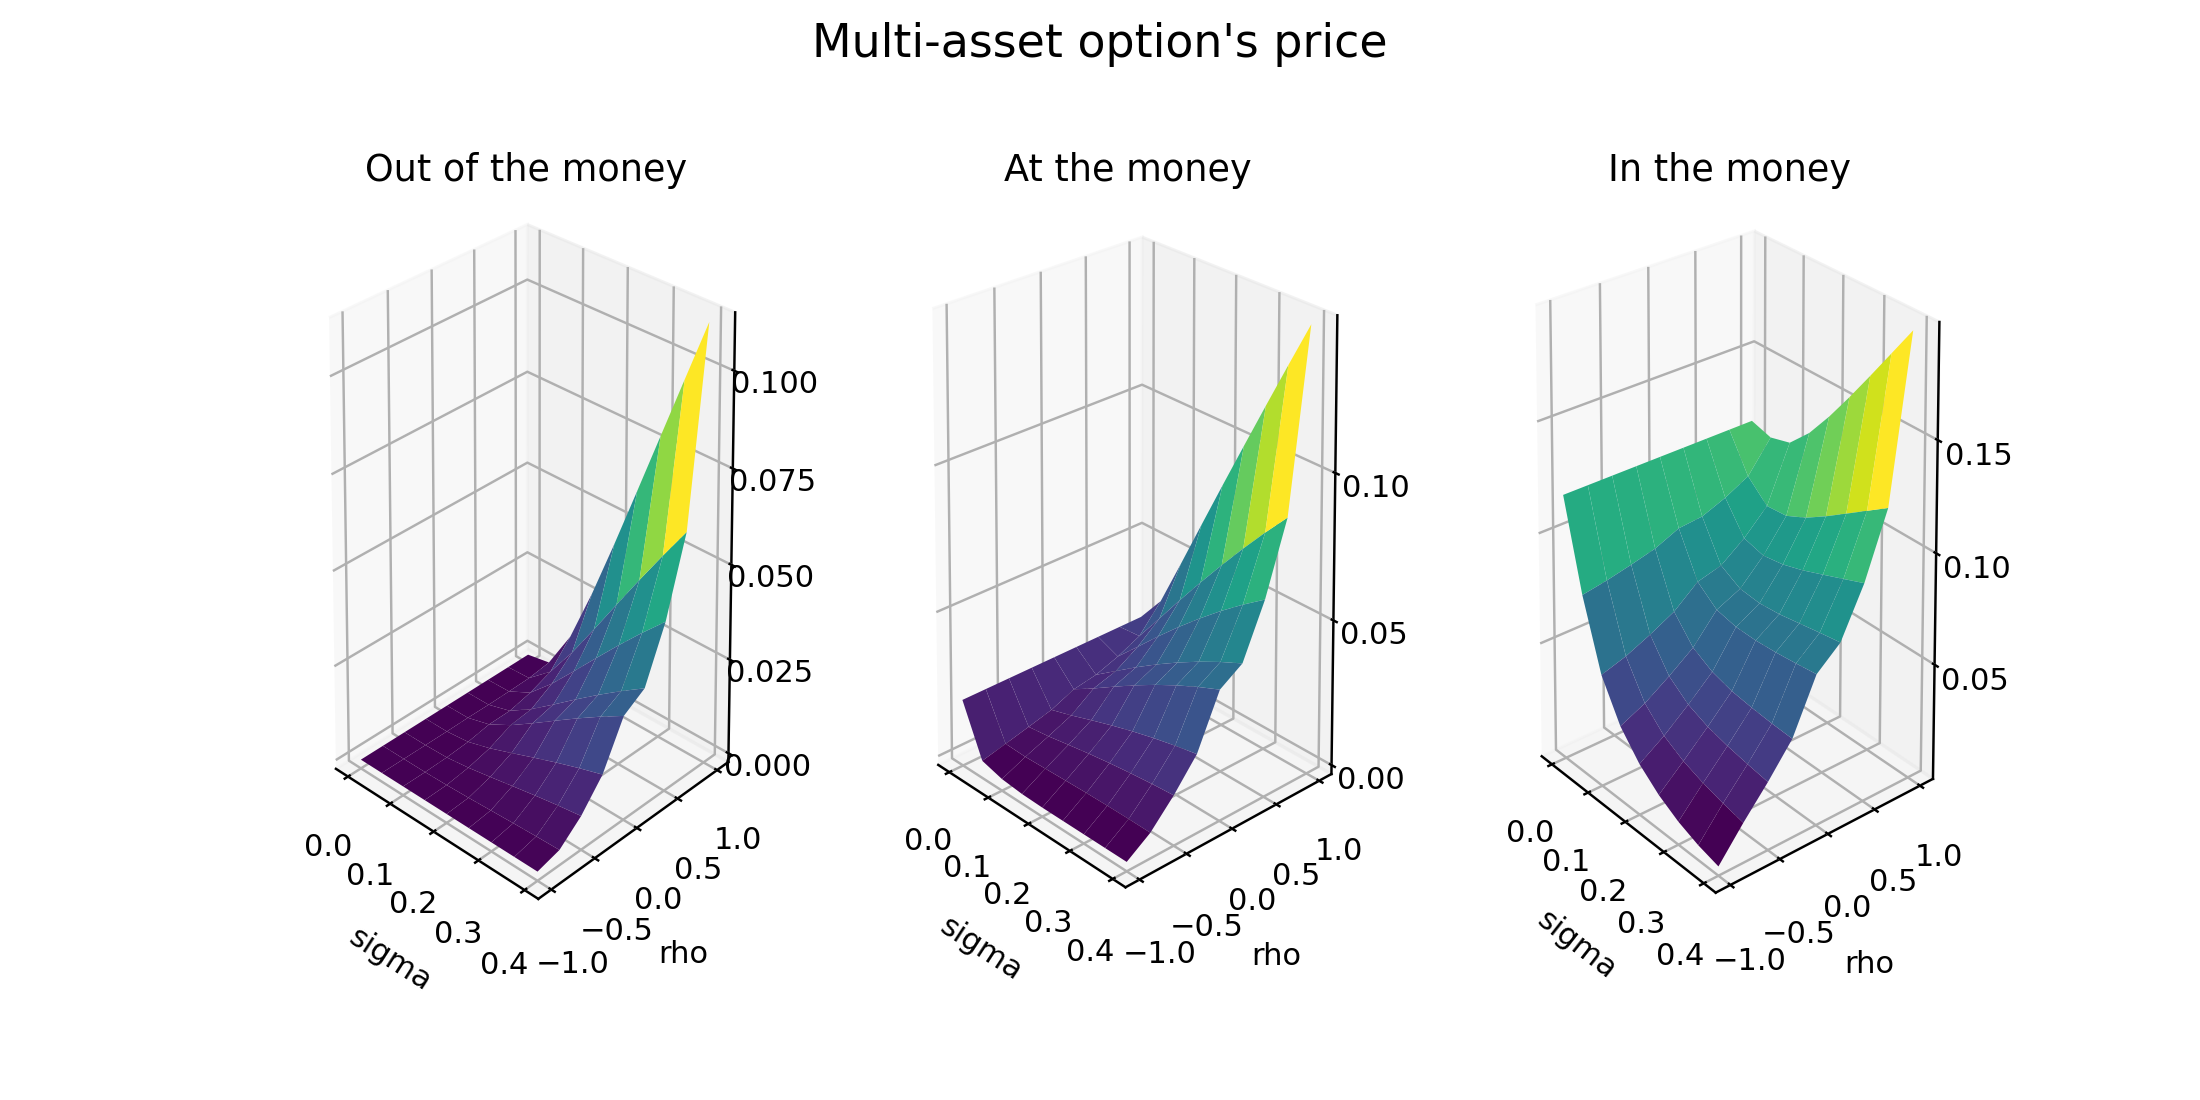

In [12]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))
fig.suptitle("Multi-asset option's price", fontsize=15)
Ks = [1.1, 1, 0.9]
msg = ["Out of the money", "At the money", "In the money"]
for ki, K in enumerate(Ks):
    mdl_payoffs = {} # models' payoffs' container
    for mdl_draw in mdl_draws:
        sigma = mdl_draw[0]
        rho = mdl_draw[1]
        draw = mdl_draw[2]
        payoffs = []
        for i in range(N):
            payoff = max(min(draw[i][-1]) - K, 0)
            payoffs.append(payoff)
        mdl_payoffs.update({(sigma, rho): payoffs})

    mdl_prics = {} # modles' prices' container
    for k, v in mdl_payoffs.items():
        price = np.exp(-r*T) * np.mean(v)
        mdl_prics.update({k: price})

    x, y = np.meshgrid(sigmas, rhos)
    z = np.zeros(shape=np.shape(x))
    for i in range(len(sigmas)):
        for j in range(len(rhos)):
            z[i, j] = mdl_prics[x[i,j], y[i,j]]
    axi = fig.add_subplot(1, len(Ks), ki+1, projection='3d')
    axi.plot_surface(x, y, z, cmap='viridis', edgecolor='none')
    axi.set_xlabel("sigma")
    axi.set_ylabel("rho")
    axi.set_title(msg[ki])

## 4. Conclusion

The relationship between multi-asset option's price, volatility and correlation is indeed unsure and somewhat complicated. It also depends on whether the option is in-the-money, at-the-money or out-of-the-money.

Looks like as the option travels from out-of-the-money to in-the-money, someone is pulling the surface upward at (sigma, rho) = (0.0, -1.0) and the monotonicity changes.

In general:
- if the option is in-the-money:
    - we want both volatility and correlation to be high, or
    - we want volatility to be low
- if the option is out-of-the-money or at-the-money:
    - we want both volatility and correlation to be high